# Import

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from os.path import basename
from os.path import join
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/tetta/.local/share/virtualenvs/research-vbjgNxHm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
from utility.utility import *
from torch import optim


content_image = load_images('input/4/4_content_sanserif_A.png', 'cpu')
opt_img = Variable(content_image.data.clone(), requires_grad=True)

optimizer = optim.LBFGS([opt_img], lr=0.001)

n = nn.Sequential(nn.Conv2d(1, 32, 4, 2, 1, bias=False), nn.ReLU(inplace=True))

l1 = torch.tensor(0., requires_grad=True)
for p in opt_img:
    l1 = l1 +  torch.norm(1.0 - p, 1)
    
# print(opt_img.shape)
smoothnes = torch.tensor(0., requires_grad=True)
for i in range(opt_img.size(2)-1):
    smoothnes = smoothnes + torch.norm(opt_img[0][0][i] - opt_img[0][0][i+1], 1)
    
print(smoothnes)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [31]:
import torch
from utility.utility import *
from sklearn.decomposition import PCA
from utility.disentangle_model import DISENTANGLE_MODEL

def visualize(s1_path, s2_path, c_path, g_path, with_relu=True):
    device = 'cuda:0'

    fig, ax = plt.subplots(1, 4, figsize=(9, 3))
    s1 = load_images(s1_path, device, crop=False)
    s2 = load_images(s2_path, device, crop=False)
    c = load_images(c_path, device, crop=False)
    g = load_images(g_path, device, crop=False)

    ax[0].set_title('s1')
    ax[0].imshow(s1.cpu().detach().clone()[0][0], cmap='gray')

    ax[1].set_title('s2')
    ax[1].imshow(s2.cpu().detach().clone()[0][0], cmap='gray')

    ax[2].set_title('c')
    ax[2].imshow(c.cpu().detach().clone()[0][0], cmap='gray')

    ax[3].set_title('g')
    ax[3].imshow(g.cpu().detach().clone()[0][0], cmap='gray')

    if with_relu == True:
        model = DISENTANGLE_MODEL(zdim=256, ch_num=26)
        model.load_state_dict(torch.load('./discentangle_model.pth'))
    else:
        from utility.models_wo_relu import DISENTANGLE_MODEL as DISENTANGLE_MODEL2
        model = DISENTANGLE_MODEL2(zdim=256, ch_num=26)
        model.load_state_dict(torch.load('./best_model_without_relu.pth', map_location='cuda:0'))
    
    for param in model.parameters():
        param.requires_grad = False
    model.to(device)
    model.eval()

    s1_feature = model(s1, [])[2].cpu().detach().clone()
    s2_feature = model(s2, [])[2].cpu().detach().clone()
    c_feature = model(c, [])[2].cpu().detach().clone()
    g_feature = model(g, [])[2].cpu().detach().clone()

    x = torch.cat([s1_feature, s2_feature, c_feature, g_feature], 0)

    # PCA
    pca = PCA()
    pca.fit(x)
    pca_feature = pca.transform(x)

    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))
    label=['s1', 's2', 'c', 'g']
    for i in range(4):
        ax2[0].scatter(pca_feature[i, 0], pca_feature[i, 1], label=label[i])
    
    ax2[0].annotate('s1-s2', xy=pca_feature[0, :2], xytext=pca_feature[1, :2], color='gray',
                arrowprops={'width': 1, 'headwidth': 10, 'shrink': 0.1, 'color': 'gray'})
    ax2[0].annotate('g-c', xy=pca_feature[3, :2], xytext=pca_feature[2, :2], color='gray',
                arrowprops={'width': 1, 'headwidth': 10, 'shrink': 0.1, 'color': 'gray'})
    ax2[0].legend()

    # Parallel coordinates plot
    # fig3, ax3 = plt.subplots(4, 1, figsize=(7, 7))
    label=['s1', 's2', 'c', 'g']
    for i in range(4):
        # ax2[1].set_title(label[i])
        ax2[1].plot(x[i], label=label[i], alpha=0.6)
    
    ax2[1].legend()
    
    # Difference between s1 and s2, g and c
    fig3, ax3 = plt.subplots(1, 2, figsize=(8, 4))
    ax3[0].plot(x[0] - x[1], label='s1-s2', alpha=0.6)
    ax3[0].plot(x[3] - x[2], label='g-c', alpha=0.6)
    ax3[0].legend()
    
    ax3[1].bar([i for i in range(128)], np.abs((x[0] - x[1]) - (x[3] - x[2])), label='diff')
    ax3[1].grid()
    ax3[1].legend()
    
    plt.show()
    
    print('font feature diff', nn.MSELoss()((x[0] - x[1]), x[3] - x[2]))

# font, class loss のみ

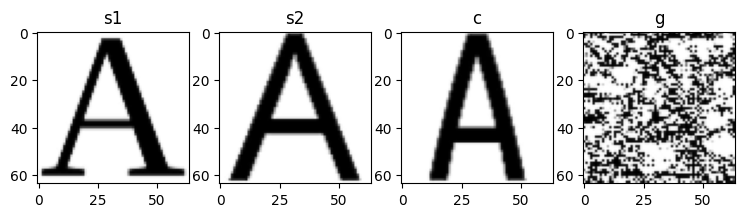

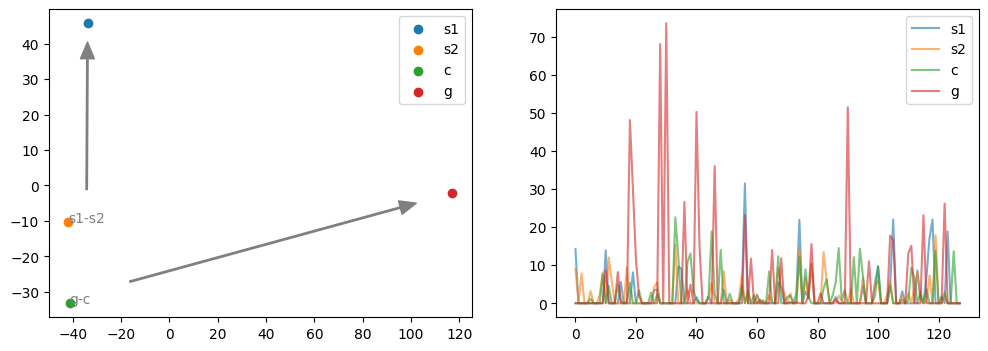

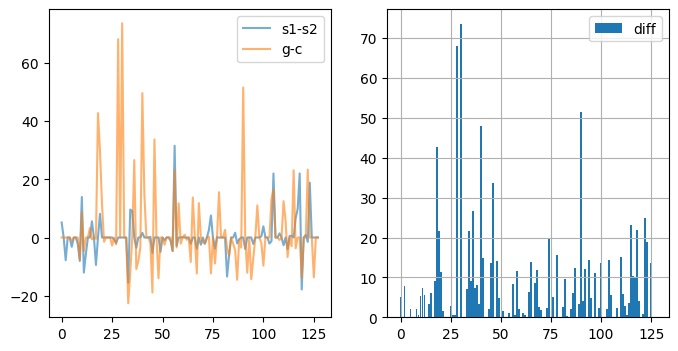

font feature diff tensor(205.3234)


In [32]:
# font loss と class loss のみ
# input 1
s1_path = 'output/646/style1.jpg'
s2_path = 'output/646/style2.jpg'
c_path = 'output/646/content.jpg'
g_path = 'output/646/[1010].jpg'

visualize(s1_path, s2_path, c_path, g_path)

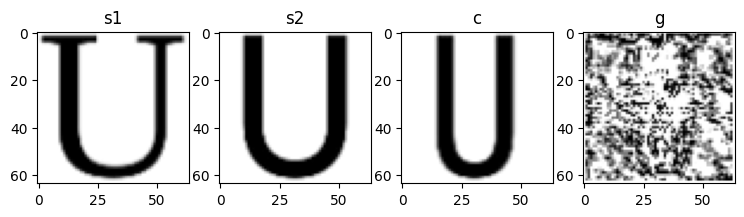

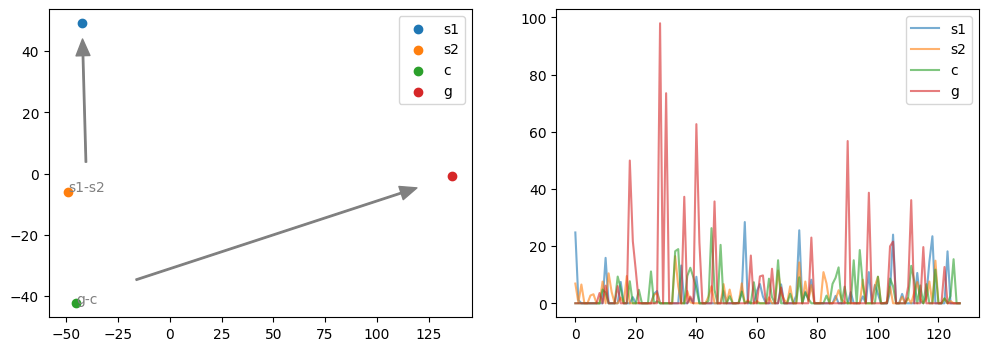

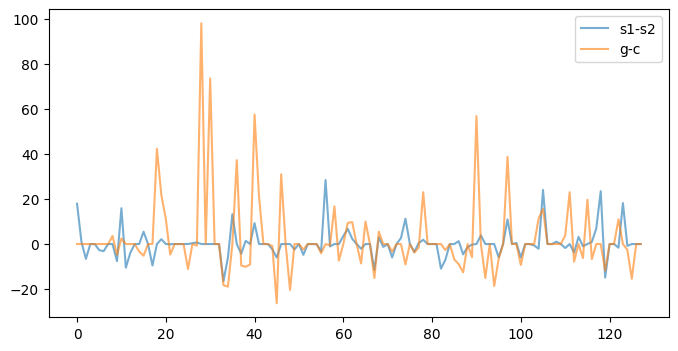

In [143]:
# font loss と class loss のみ
# input 2
s1_path = 'output/647/style1.jpg'
s2_path = 'output/647/style2.jpg'
c_path = 'output/647/content.jpg'
g_path = 'output/647/[1004].jpg'

visualize(s1_path, s2_path, c_path, g_path)

[ WARN:0@4.972] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('output/678/style1.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

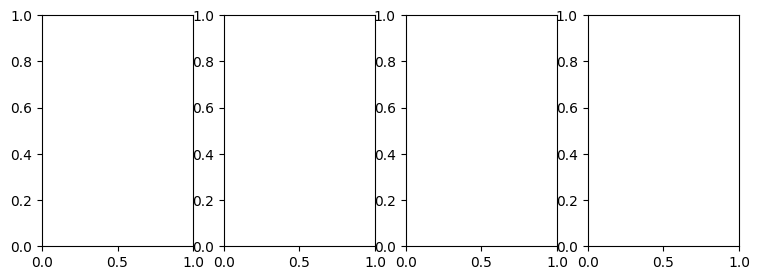

In [3]:
# font loss と class loss のみ
# input 4
s1_path = 'output/678/style1.jpg'
s2_path = 'output/678/style2.jpg'
c_path = 'output/678/content.jpg'
g_path = 'output/678/[1001].jpg'

visualize(s1_path, s2_path, c_path, g_path)

# font, class loss のみ（w/o RELU）

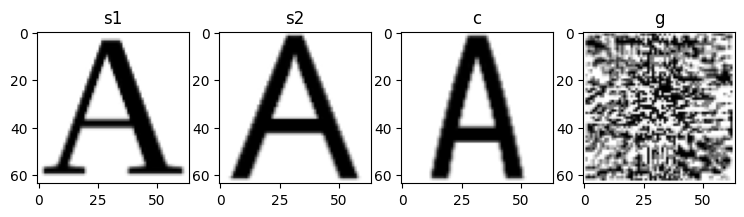

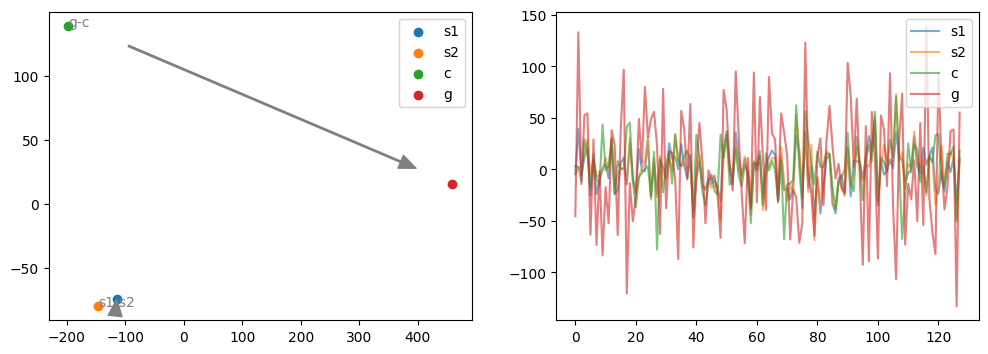

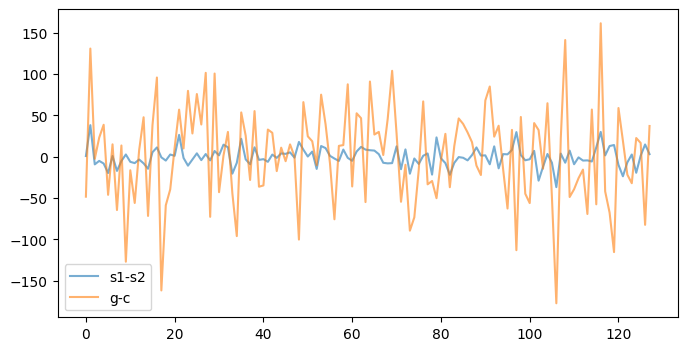

font feature diff tensor(3308.1062)


In [4]:
# font loss と class loss のみ w/o relu
# input 1
s1_path = 'output/657_hara_wo_relu_font_class/style1.jpg'
s2_path = 'output/657_hara_wo_relu_font_class/style2.jpg'
c_path = 'output/657_hara_wo_relu_font_class/content.jpg'
g_path = 'output/657_hara_wo_relu_font_class/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

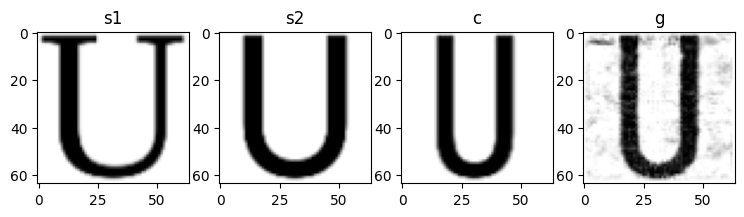

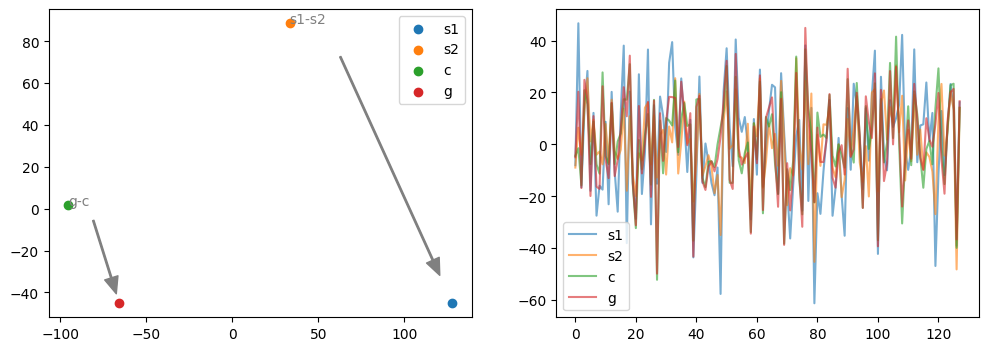

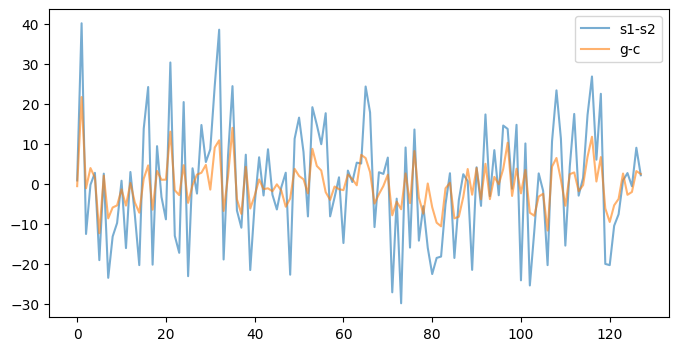

font feature diff tensor(103.5936)


In [5]:
# font loss と class loss のみ w/o relu
# input 2
s1_path = 'output/658/style1.jpg'
s2_path = 'output/658/style2.jpg'
c_path = 'output/658/content.jpg'
g_path = 'output/658/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

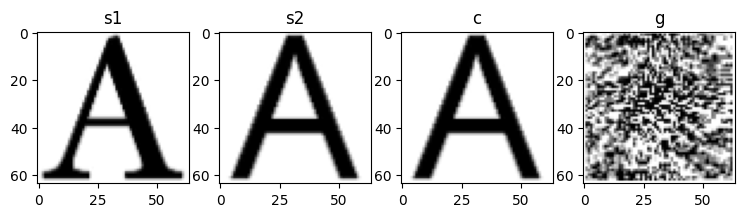

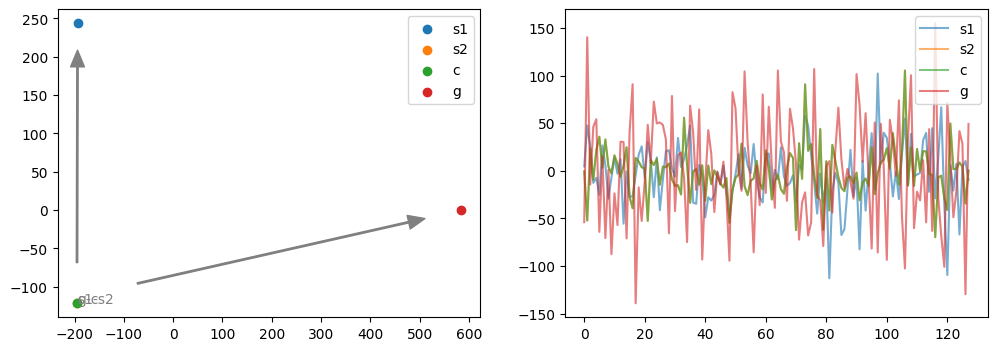

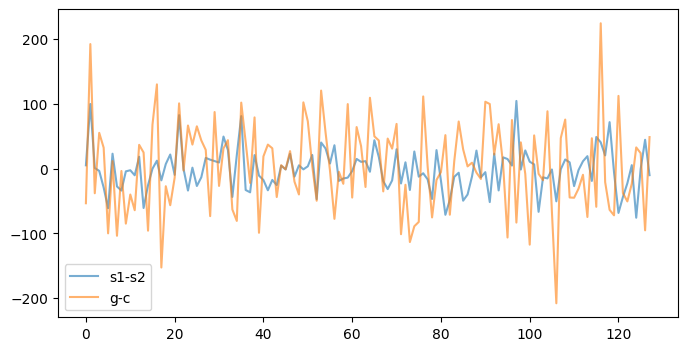

In [162]:
# font loss と class loss のみ w/o relu
# input 4
s1_path = 'output/659/style1.jpg'
s2_path = 'output/659/style2.jpg'
c_path = 'output/659/content.jpg'
g_path = 'output/659/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

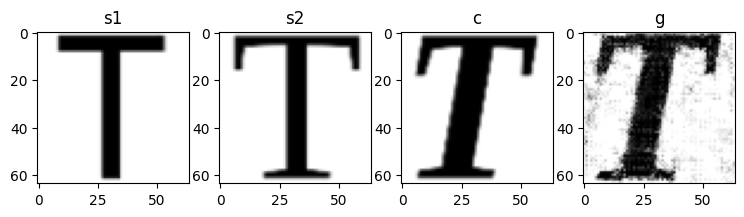

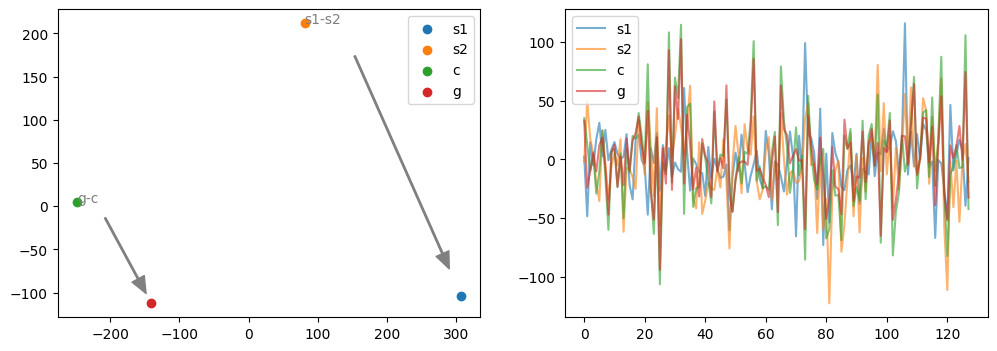

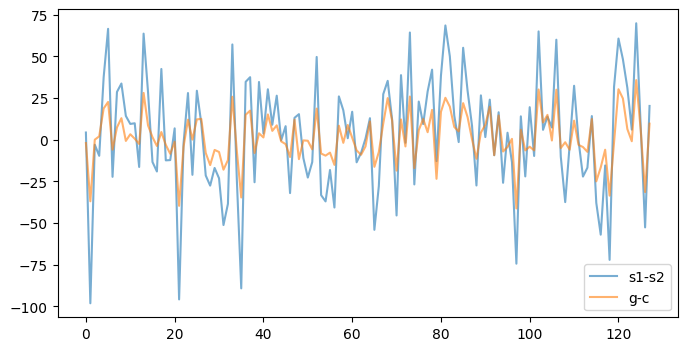

font feature diff tensor(462.0573)


In [6]:
# font loss と class loss のみ w/o relu
# input 
s1_path = 'output/661/style1.jpg'
s2_path = 'output/661/style2.jpg'
c_path = 'output/661/content.jpg'
g_path = 'output/661/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

In [67]:
i = torch.load('output/798/opt_img.pt')
print(i[:1])

i2 = cv2.imread('output/798/[1020].jpg', 0)/255.0
# i2 = cv2.resize(i2,(64, 64),interpolation=cv2.INTER_CUBIC)
print(i2[:1])

# same to opencv 
# from PIL import Image
# i3 = Image.open('output/798/[1020].jpg')
# print(np.array(i3)[:1]/255.0)

print(sum([abs(x-y) for x, y in zip(i[0], i2[0])]))

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9749, 0.9946, 0.9551,
         0.9759, 0.9356, 0.9787, 0.9239, 0.9634, 0.9107, 0.8900, 0.9594, 0.9841,
         0.9692, 0.9482, 0.9466, 0.9310, 0.9419, 0.9804, 0.9685, 0.9212, 0.8981,
         0.9384, 0.9323, 0.9851, 0.9242, 0.9884, 0.9875, 0.9964, 0.9972, 0.9910,
         0.9592, 0.9326, 0.9712, 0.9660, 0.9831, 0.9897, 0.9990, 0.9959, 0.9986,
         0.9981, 0.9984, 0.9972, 0.9977, 0.9981, 0.9992, 0.9958, 0.9981, 1.0000,
         0.9991, 0.9919, 0.9880, 0.9394, 0.9794, 0.9437, 0.9720, 0.9615, 0.9507,
         0.9764]])
[[1.         1.         0.94901961 1.         1.         0.94509804
  1.         1.         0.96078431 0.92941176 0.96078431 0.97254902
  0.89411765 0.98823529 0.89019608 0.89411765 0.97254902 0.96862745
  0.95294118 0.97647059 0.90196078 0.95686275 0.94509804 0.95294118
  0.95686275 0.88235294 0.87843137 0.95294118 0.9254902  0.97254902
  0.89411765 1.         0.96862745 1.         0.97647059 1.
  0.93333333 0

In [131]:
import torch
from torchvision import transforms

t = torch.rand((32,32))
print('GT:', t[0])
# torch.save(t, 'test.pt')

# i = postp(t, 64, False)

i1 = transforms.ToPILImage()(t)
print('pillow:', np.array(i1)[0]/255)

print('diff:', sum([abs(x-y) for x, y in zip(t[0], np.array(i1)[0]/255)]))

i2 = transforms.ToPILImage(mode='F')(t)
print('after:', np.array(i2)[0])
print('diff2:', sum([abs(x-y) for x, y in zip(t[0], np.array(i2)[0])]))


GT: tensor([0.3650, 0.1770, 0.5829, 0.5434, 0.9503, 0.7341, 0.3346, 0.2975, 0.8329,
        0.6542, 0.2839, 0.3292, 0.0574, 0.6192, 0.0489, 0.2364, 0.2250, 0.5073,
        0.4339, 0.2302, 0.7524, 0.7279, 0.2349, 0.5964, 0.0390, 0.5416, 0.4292,
        0.5465, 0.7586, 0.8486, 0.7653, 0.3391])
pillow: [0.36470588 0.17647059 0.58039216 0.54117647 0.94901961 0.73333333
 0.33333333 0.29411765 0.83137255 0.65098039 0.28235294 0.3254902
 0.05490196 0.61568627 0.04705882 0.23529412 0.22352941 0.50588235
 0.43137255 0.22745098 0.74901961 0.7254902  0.23137255 0.59607843
 0.03529412 0.54117647 0.42745098 0.54509804 0.75686275 0.84705882
 0.76470588 0.3372549 ]
diff: tensor(0.0617)
after: [0.36495823 0.17698348 0.58286    0.54335666 0.9503171  0.73407996
 0.33459145 0.2975452  0.83289635 0.6541967  0.28392583 0.32916272
 0.05742419 0.61918825 0.0488739  0.23635626 0.224976   0.50729877
 0.43387192 0.23021579 0.75238305 0.72785026 0.23486757 0.59644026
 0.03896958 0.5415954  0.42920434 0.5464829  

# font, class loss のみ （w/o RELU w/ clamp）

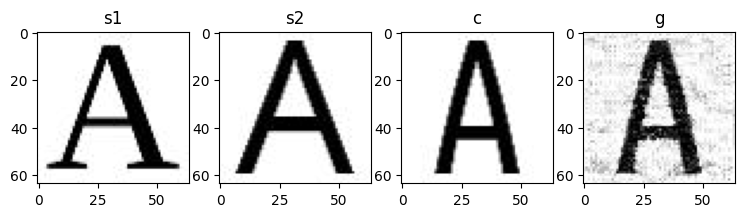

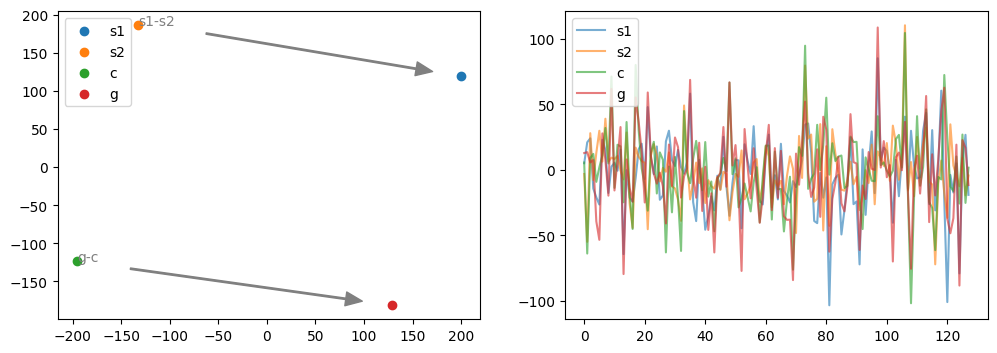

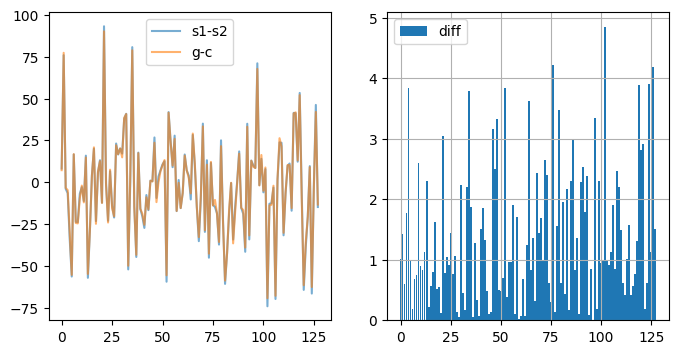

font feature diff tensor(3.1780)


In [33]:
# font loss と class loss のみ w/o relu w/ clamp
# input 
s1_path = 'output/781_haraworelu_fontclass/style1.jpg'
s2_path = 'output/781_haraworelu_fontclass/style2.jpg'
c_path = 'output/781_haraworelu_fontclass/content.jpg'
g_path = 'output/781_haraworelu_fontclass/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

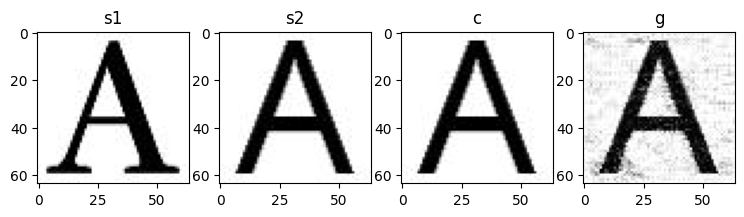

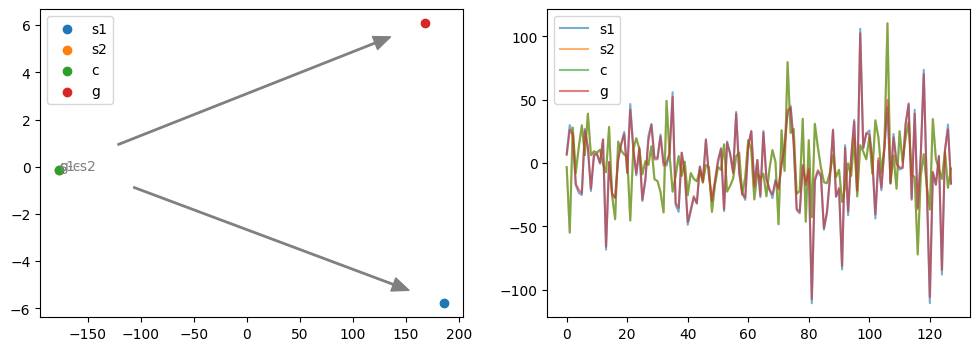

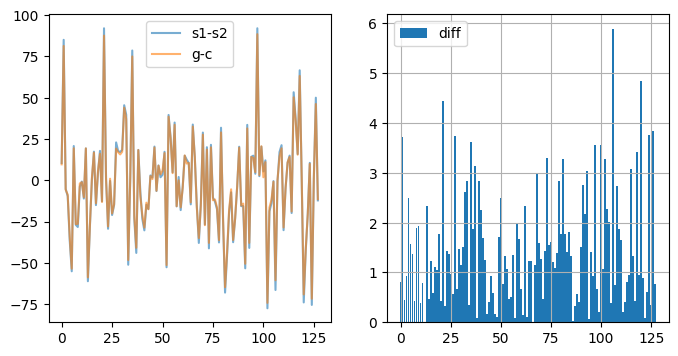

font feature diff tensor(3.5618)


In [34]:
# font loss と class loss のみ w/o relu w/ clamp
# input 
s1_path = 'output/783/style1.jpg'
s2_path = 'output/783/style2.jpg'
c_path = 'output/783/content.jpg'
g_path = 'output/783/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

In [6]:
i = torch.load('output/783/opt_img.pt')
print('ラストエポックでのopt img tensor', i.shape)
print(i)

i2 = load_images('output/783/[1020].jpg', 'cpu', crop=False)
print('生成後に読み込み', i2.shape)
print(i2)

ラストエポックでのopt img tensor torch.Size([1, 64, 64])
tensor([[[0.9989, 1.0000, 1.0000,  ..., 0.9640, 0.9660, 0.9852],
         [0.9999, 0.9809, 0.8511,  ..., 0.9144, 0.8904, 0.9865],
         [1.0000, 1.0000, 0.9280,  ..., 0.8864, 0.9987, 0.9336],
         ...,
         [0.9968, 0.9399, 0.9813,  ..., 0.9864, 0.9989, 0.9956],
         [0.9591, 0.9717, 0.9669,  ..., 0.9878, 0.9550, 0.9928],
         [0.9917, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])
生成後に読み込み torch.Size([1, 1, 64, 64])
tensor([[[[0.9882, 1.0000, 1.0000,  ..., 0.9608, 0.9725, 1.0000],
          [1.0000, 1.0000, 0.7255,  ..., 0.9059, 0.9098, 0.9333],
          [1.0000, 0.9255, 1.0000,  ..., 0.9412, 0.9529, 0.9765],
          ...,
          [0.9922, 0.8706, 1.0000,  ..., 1.0000, 0.9804, 0.9529],
          [0.9529, 1.0000, 0.9294,  ..., 0.9529, 0.9412, 1.0000],
          [0.9922, 0.9647, 1.0000,  ..., 1.0000, 1.0000, 0.9686]]]])


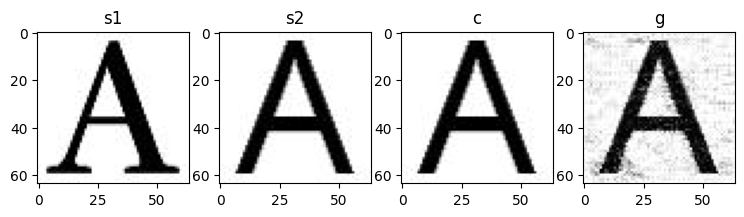

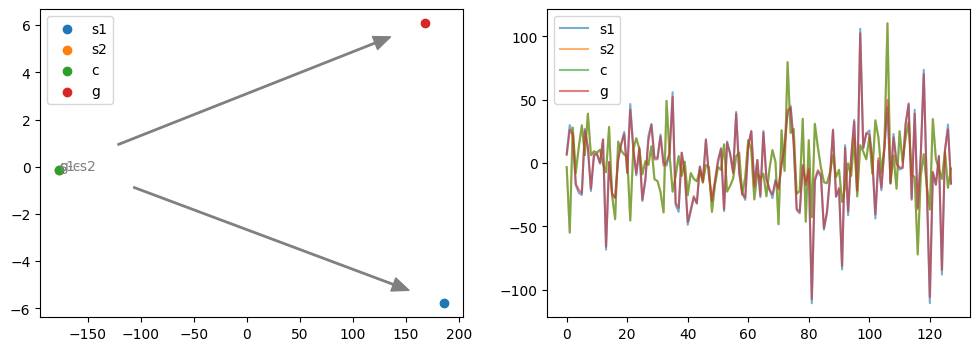

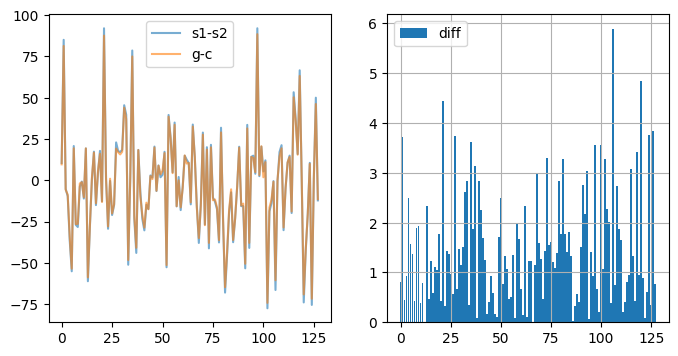

font feature diff tensor(3.5618)


In [35]:
# font loss と class loss のみ w/o relu w/ clamp
# input 
s1_path = 'output/783/style1.jpg'
s2_path = 'output/783/style2.jpg'
c_path = 'output/783/content.jpg'
g_path = 'output/783/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

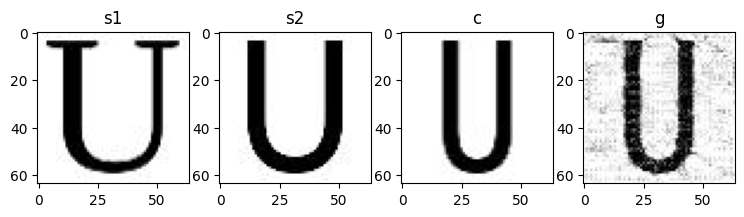

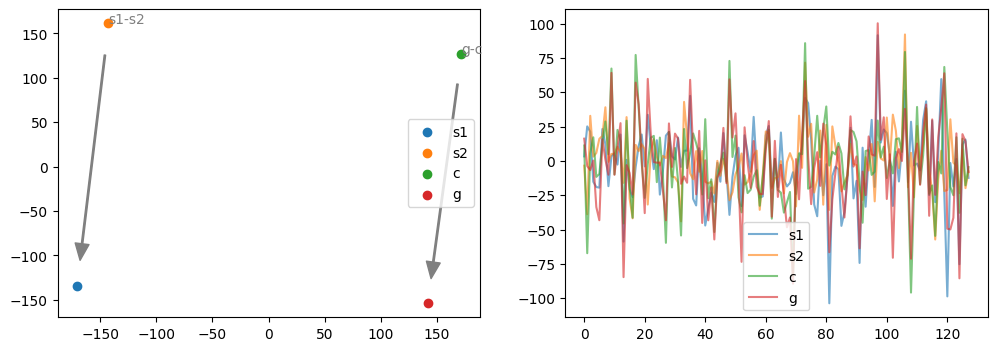

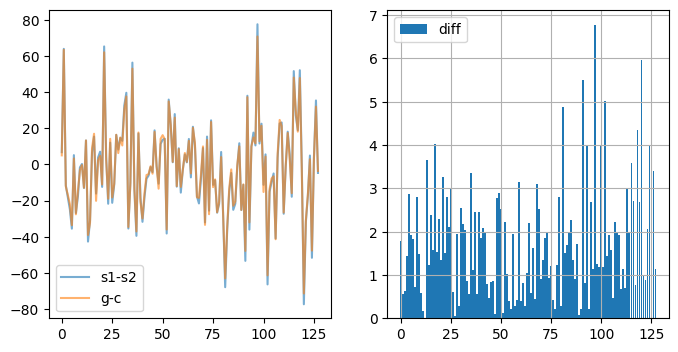

font feature diff tensor(4.7523)


In [36]:
# font loss と class loss のみ w/o relu w/ clamp
# input 
s1_path = 'output/782/style1.jpg'
s2_path = 'output/782/style2.jpg'
c_path = 'output/782/content.jpg'
g_path = 'output/782/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

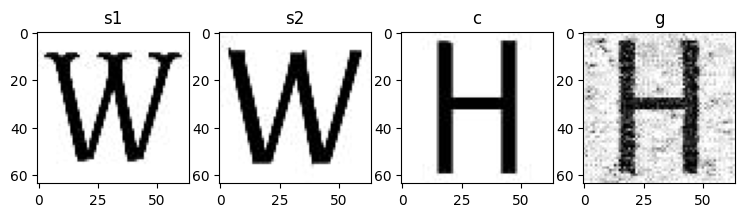

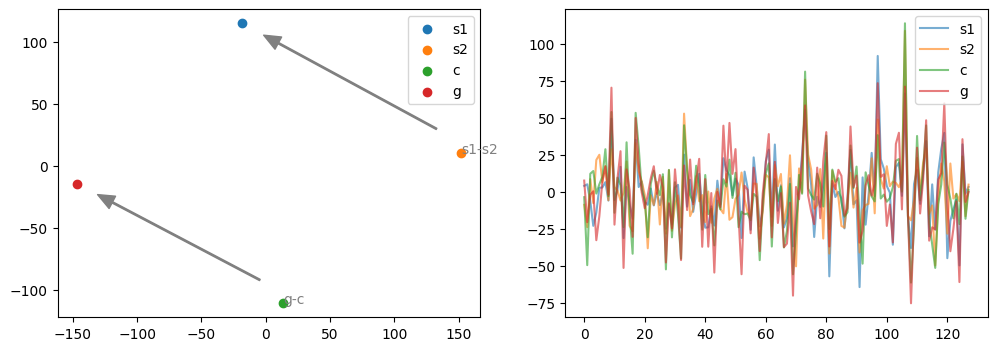

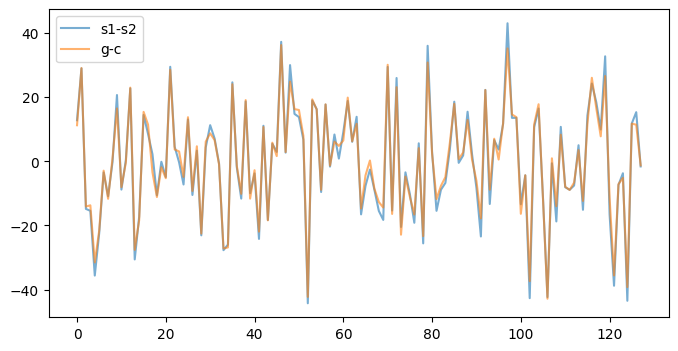

font feature diff tensor(5.4634)


In [9]:
# font loss と class loss のみ w/o relu w/ clamp
# input 
s1_path = 'output/786/style1.jpg'
s2_path = 'output/786/style2.jpg'
c_path = 'output/786/content.jpg'
g_path = 'output/786/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

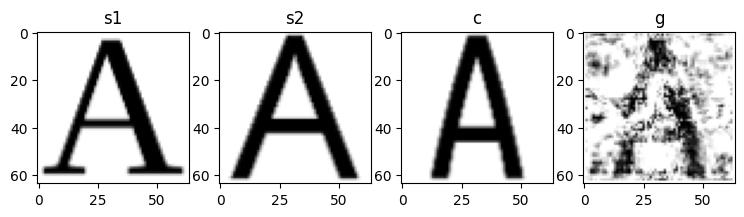

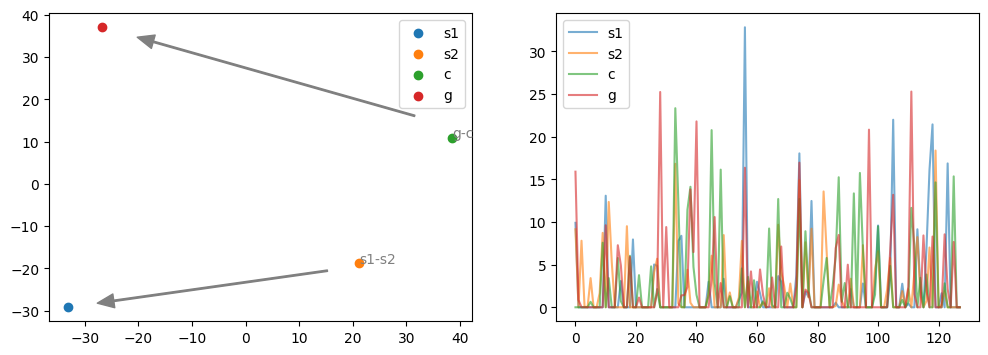

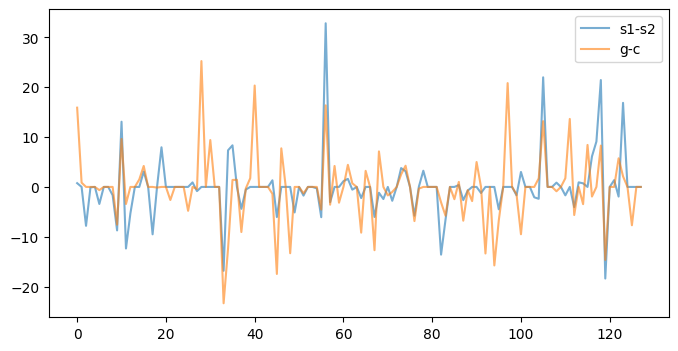

In [144]:
# 全てのloss
# input 1
s1_path = 'output/648/style1.jpg'
s2_path = 'output/648/style2.jpg'
c_path = 'output/648/content.jpg'
g_path = 'output/648/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path)

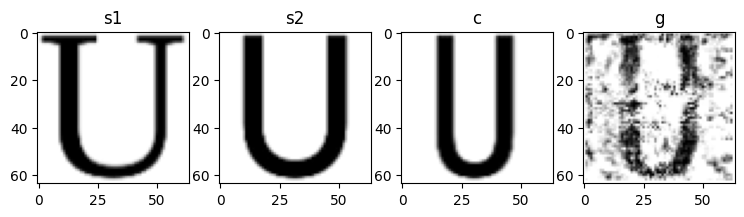

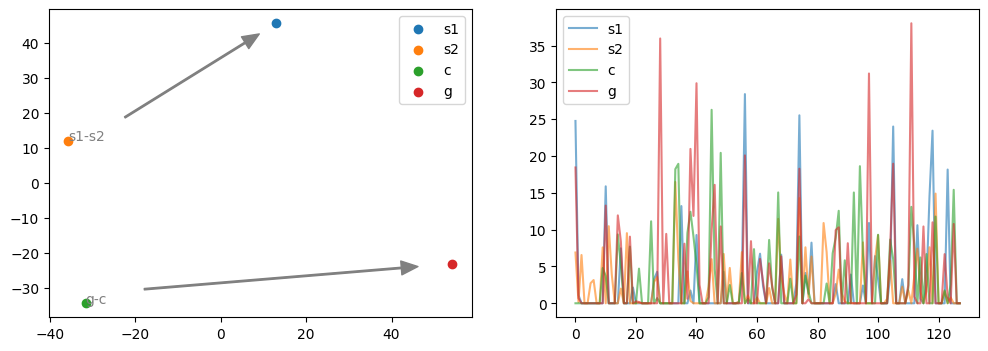

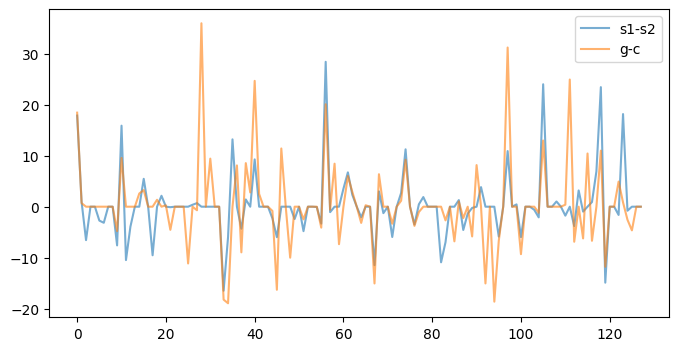

In [145]:
# 全てのloss
# input 2
s1_path = 'output/649/style1.jpg'
s2_path = 'output/649/style2.jpg'
c_path = 'output/649/content.jpg'
g_path = 'output/649/[1004].jpg'

visualize(s1_path, s2_path, c_path, g_path)

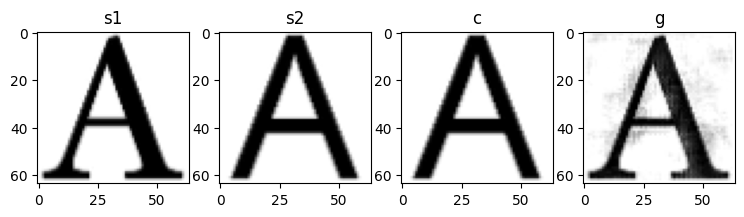

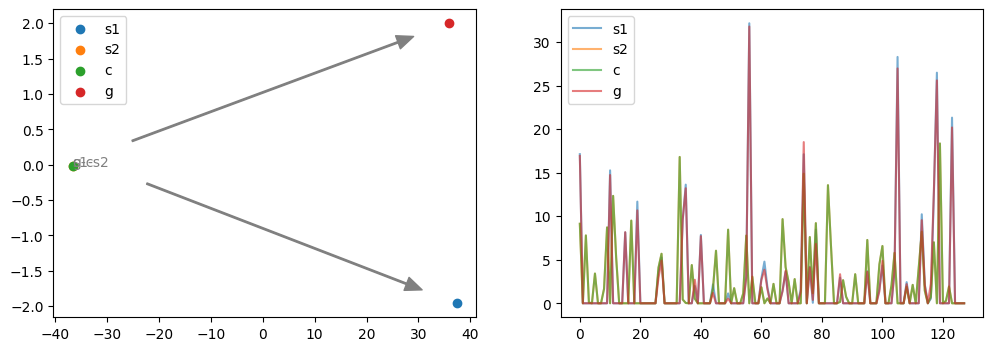

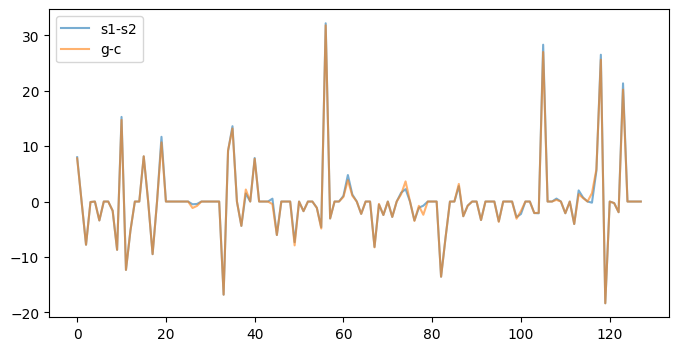

In [146]:
# 全てのloss
# input 4
s1_path = 'output/652/style1.jpg'
s2_path = 'output/652/style2.jpg'
c_path = 'output/652/content.jpg'
g_path = 'output/652/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path)

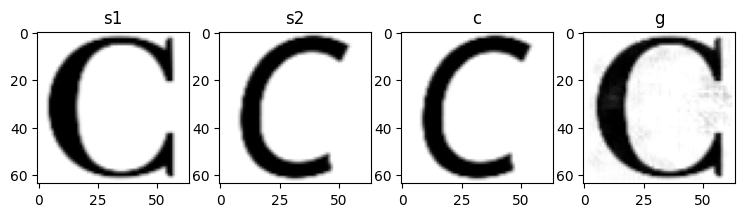

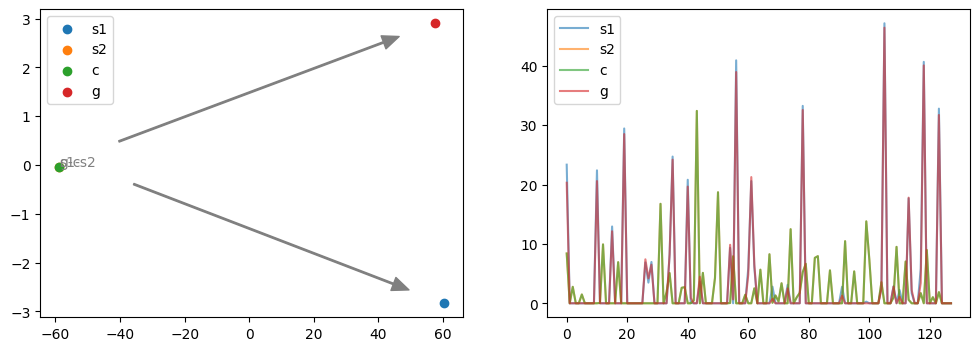

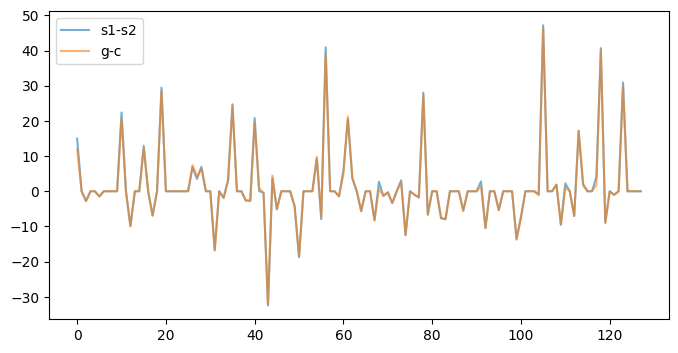

In [150]:
# 全てのloss
# input 31
s1_path = 'output/656/style1.jpg'
s2_path = 'output/656/style2.jpg'
c_path = 'output/656/content.jpg'
g_path = 'output/656/[1020].jpg'

visualize(s1_path, s2_path, c_path, g_path)

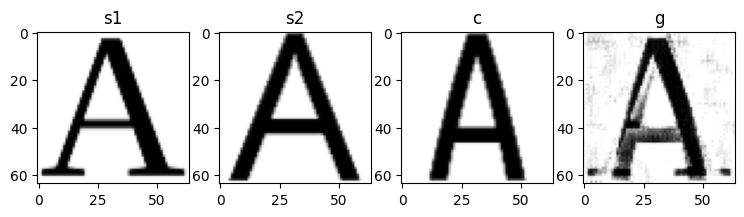

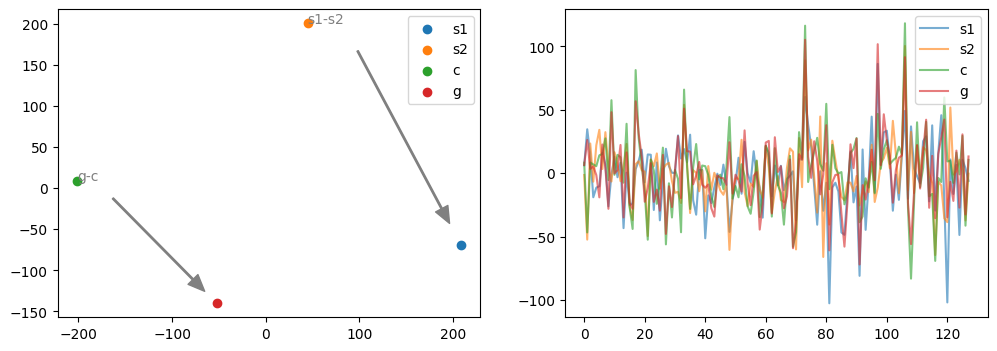

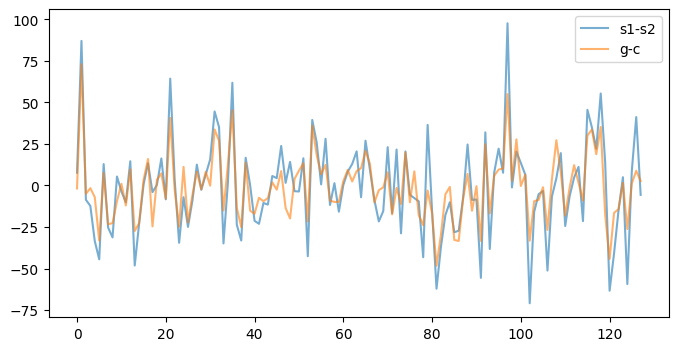

font feature diff tensor(197.4835)


In [15]:
# 全てのloss w/o relu
s1_path = 'output/693_hara_wo_relu_1e4/style1.jpg'
s2_path = 'output/693_hara_wo_relu_1e4/style2.jpg'
c_path = 'output/693_hara_wo_relu_1e4/content.jpg'
g_path = 'output/693_hara_wo_relu_1e4/[1003].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

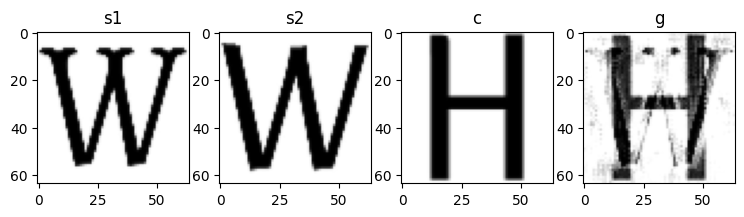

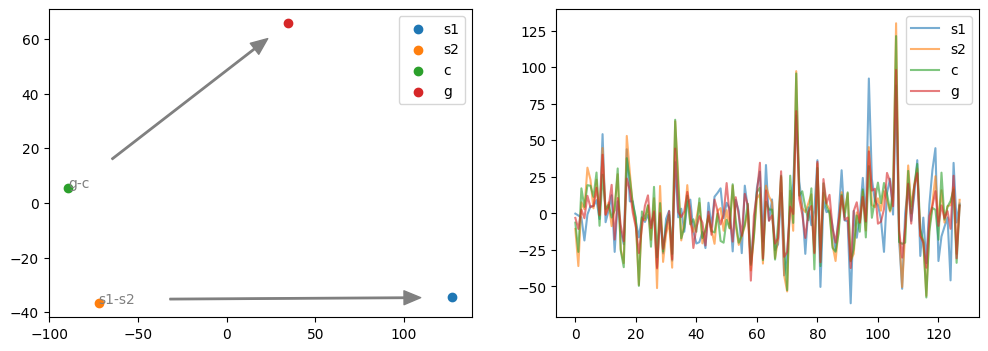

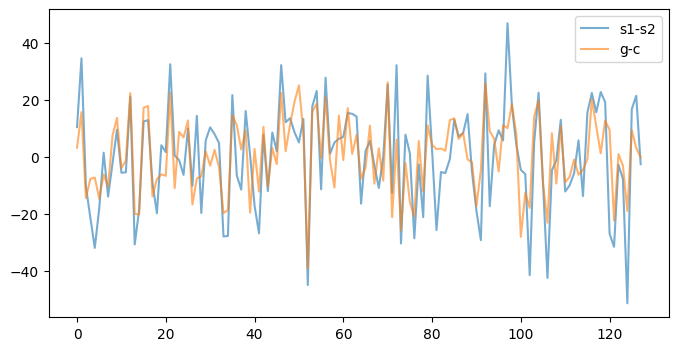

font feature diff tensor(149.7551)


In [12]:
# 全てのloss w/o relu
s1_path = 'output/698/style1.jpg'
s2_path = 'output/698/style2.jpg'
c_path = 'output/698/content.jpg'
g_path = 'output/698/[1009].jpg'

visualize(s1_path, s2_path, c_path, g_path, with_relu=False)

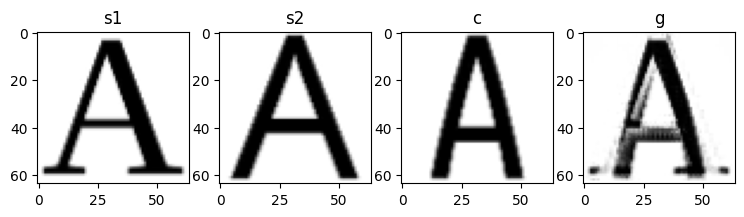

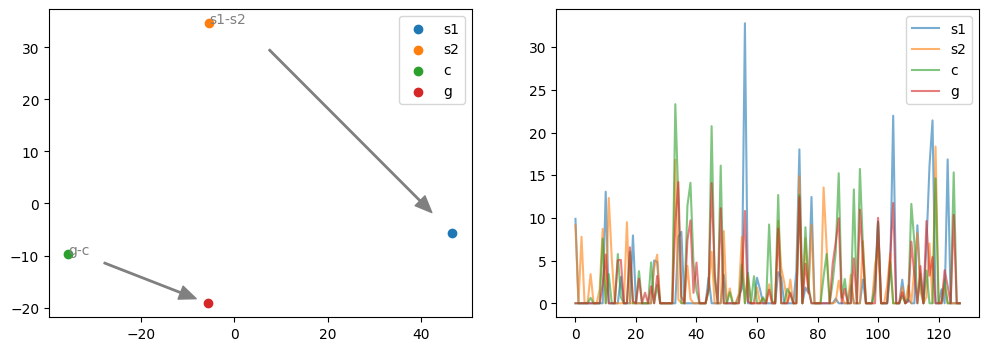

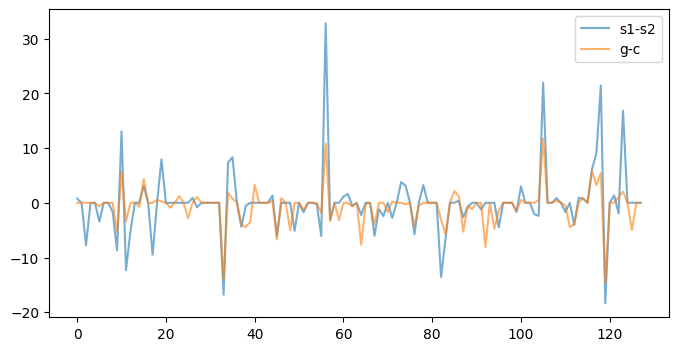

In [147]:
# style loss と content loss のみ
# input 1
s1_path = 'output/650/style1.jpg'
s2_path = 'output/650/style2.jpg'
c_path = 'output/650/content.jpg'
g_path = 'output/650/[1003].jpg'

visualize(s1_path, s2_path, c_path, g_path)

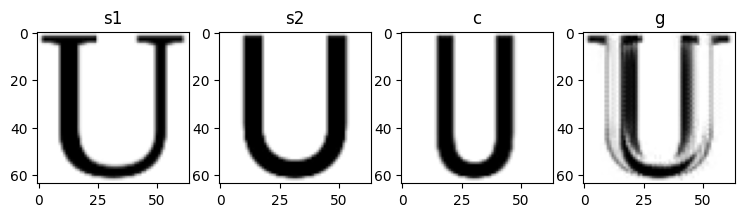

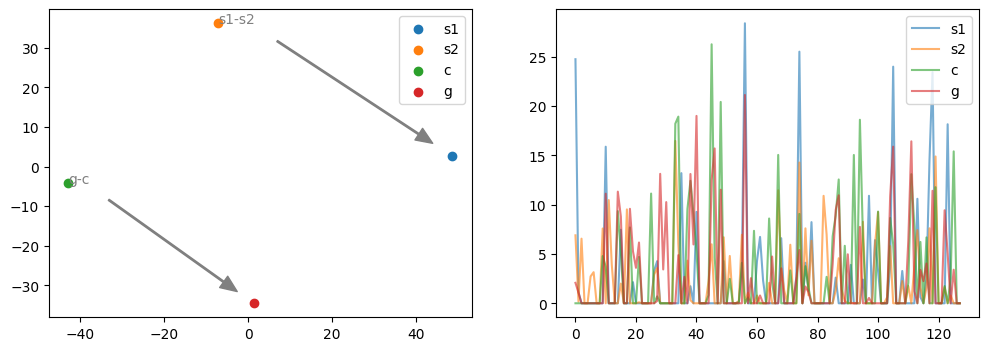

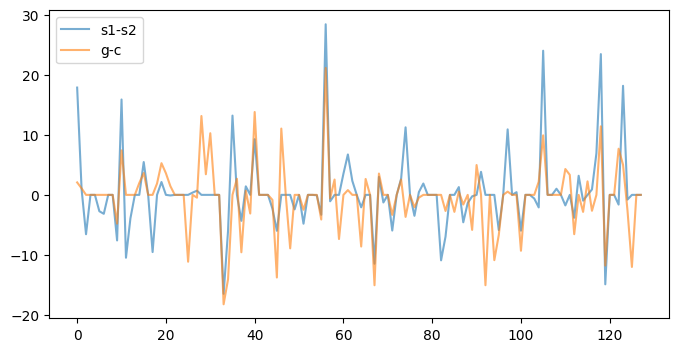

In [148]:
# style loss と content loss のみ
# input 2
s1_path = 'output/651/style1.jpg'
s2_path = 'output/651/style2.jpg'
c_path = 'output/651/content.jpg'
g_path = 'output/651/[1018].jpg'

visualize(s1_path, s2_path, c_path, g_path)

In [10]:
class DISENTANGLE_MODEL(nn.Module):
    def __init__(self, zdim, ch_num):
        super().__init__()
        self.zdim = zdim
        self.ch_num = ch_num
        hidden_units = 512

        self.encoder = nn.Sequential(
                    nn.Conv2d(1, 32, 4, 2, 1, bias=False),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 64, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(128),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, 4, 1, 1, bias=False),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
        )
        self.fc_c = nn.Sequential(
                    nn.Linear(256*7*7, hidden_units),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(hidden_units, int(zdim/2)),
                    nn.ReLU(inplace=True)
                    )
        self.fc_f = nn.Sequential(
                    nn.Linear(256*7*7, hidden_units),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5),
                    nn.Linear(hidden_units, int(zdim/2)),
                    nn.ReLU(inplace=True)
                    )
        self.classifier_c = nn.Sequential(
                            nn.Linear(int(zdim/2),ch_num),
#                             nn.Softmax(dim=1)
        )
        self.upsample = nn.Sequential(
            nn.Linear(zdim, 256*7*7),
            nn.ReLU(inplace=True))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, layer_key):
        middle_outputs = {}
        
        conv_cnt = 0
        for layer in self.encoder.children():
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                conv_cnt += 1
            elif isinstance(layer, nn.ReLU):
                key = 'conv{}'.format(conv_cnt)
                middle_outputs[key] = x                
        
        z = x.view(x.shape[0], -1)
        z_c = self.fc_c(z)
        z_f = self.fc_f(z)
        # output_c = self.classifier_c(z_c)

        return [middle_outputs[k] for k in layer_key], z_c, z_f
    
    
x = torch.zeros((1,1,64,64))
model = DISENTANGLE_MODEL(256, 26)

layers = ['conv1', 'conv2', 'conv3']
out, z_c, z_f = model(x, layers)
print(out[0].shape)

torch.Size([1, 32, 32, 32])


In [8]:
from utility.utility import load_images
from utility.vgg_network_with_top import VGG as VGGWithTOP

f = 'output/265/[1020].jpg'
img = load_images(f, 256, 'cuda:0', 1)
# print(img)
# vgg_with_top = VGGWithTOP()
# vgg_with_top.load_state_dict(torch.load('./vgg_with_top.pth'))
from torchvision import models
vgg_with_top = models.resnet18(weights=None)
vgg_with_top.fc = nn.Linear(512, 26)
vgg_with_top.load_state_dict(torch.load('./resnet_0_1.pth'))

for param in vgg_with_top.parameters():
    param.requires_grad = False
vgg_with_top.to('cuda:0')
vgg_with_top.eval()

content_class = 'A'
label = torch.tensor([i for i in range(26) if chr(i+ord('A')) == content_class]).to('cuda:0')
# logit = vgg_with_top(img, ['fc3'])[0]
logit = vgg_with_top(img)
# print(logit)
prob = nn.Softmax(dim=1)(logit)
print(prob)
pred_label = torch.max(prob, 1)[1].item()
print('class', chr(ord('A') + pred_label))
loss = nn.CrossEntropyLoss()(logit, label)
print(loss)


tensor([[1.5791e-09, 2.1640e-08, 2.5100e-08, 6.6962e-09, 3.2617e-07, 1.8972e-11,
         7.3669e-08, 1.9988e-08, 4.7147e-03, 9.0731e-08, 3.3016e-08, 9.9518e-01,
         8.4838e-13, 1.5790e-09, 5.2730e-12, 5.4941e-11, 6.6949e-08, 1.9095e-09,
         2.8374e-08, 1.0302e-09, 2.6120e-09, 2.1241e-09, 6.2753e-14, 3.7070e-09,
         5.2187e-08, 1.0815e-04]], device='cuda:0')
class L
tensor(20.2664, device='cuda:0')


In [63]:
from train_vgg import make_dataloader

d = make_dataloader()
print(d['test'].dataset[0][0][0][100:120,100:120])

TRAIN SIZE:  41990
VAL SIZE:  13624
TEST SIZE:  25714
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1608, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.5412, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0157, 0.9059, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3020, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.6863, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
      

In [14]:
from train_vgg import make_path_list, make_dataloader

# t, _, _ = make_path_list()
# print(t[:10])
d = make_dataloader('cpu')
plt.figure(figsize =(10, 10))
for i, l in d['train']:
    for _i, _l in zip(i, l): 
        plt.subplot(4, 7, _l.item()+1)
        plt.imshow(_i[0], cmap='gray')

plt.figure(figsize =(10, 10))
for i, l in d['val']:
    for _i, _l in zip(i, l): 
        plt.subplot(4, 7, _l.item()+1)
        plt.imshow(_i[0], cmap='gray')

TypeError: make_dataloader() takes 0 positional arguments but 1 was given

In [2]:
from utility.vgg_network_with_top import VGG, Model
from train_vgg import make_path_list, make_dataloader

d = make_dataloader('cpu')
vgg = VGG(26)
vgg.eval()

# vgg2 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', init_weights=False)
# vgg2.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
# vgg2.avgpool = nn.AdaptiveAvgPool2d((8, 8))
# vgg2.classifier[0] = nn.Linear(512*8*8, 4096)
# vgg2.classifier[6] = nn.Linear(4096, 26)
# vgg2.eval()

# m = Model()
# m.eval()

i = torch.randn(10, 1, 256, 256)
print('i', i)
with torch.no_grad():
    print('out1', vgg(i, ['fc3']))
    print('out2', vgg2(i))

for i, l in d['train']:
    o1 = vgg(i, ['fc3'])
    # o2 = vgg2(i)
    break

print(o1)
# print(o2)

TRAIN SIZE:  41990
VAL SIZE:  13624
TEST SIZE:  25714
i tensor([[[[-0.5423,  0.3065, -0.3376,  ..., -0.4974,  0.8768, -0.1035],
          [ 0.5822, -1.0294,  0.9340,  ..., -0.1026, -0.9206, -0.1713],
          [ 0.6879, -2.0340,  0.6456,  ..., -0.3766, -0.7715,  0.8524],
          ...,
          [ 1.7260,  1.2476, -0.6634,  ..., -2.3865,  0.3136,  0.0300],
          [-0.4887, -0.4332,  0.0106,  ...,  0.6427, -0.3805, -0.1196],
          [-0.0113,  0.9679, -2.3826,  ..., -1.8271,  0.2571,  0.6796]]],


        [[[-0.5027, -1.1181,  1.0078,  ..., -0.8235,  0.5323, -1.1458],
          [-1.0572,  1.1472,  0.2468,  ...,  1.1336,  0.1664, -0.9696],
          [-0.9418, -0.1571, -0.3978,  ...,  1.3375,  0.2424,  0.0682],
          ...,
          [-0.9631, -1.0917,  1.7891,  ..., -1.3390,  0.6551,  1.1878],
          [-0.2230,  0.2640, -0.2684,  ..., -0.8585, -0.1678, -1.2309],
          [-1.1352,  0.5258,  0.1004,  ...,  2.0580,  0.0970, -0.8208]]],


        [[[-1.6625,  0.9490,  1.8656,  ...

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[10, 1, 256, 256] to have 3 channels, but got 1 channels instead

In [16]:
a = torch.unsqueeze(torch.tensor(0), dim=0)
print(a.shape)

torch.Size([1])


In [2]:
from torchvision import transforms
from utility.utility import load_images, max_min_scale

f = '../font2img/image/Abel-Regular/D.png'
# f = '/home/tetta/Pictures/tetta_kondo.JPG'
i = load_images(f, 256, 'cpu', 1)

# print(i.shape)
# print(i[0][0][0:5, 0:5])
# print(i[0][0][100:120, 80:90])
# plt.imshow(i[0].permute(1,2,0))
# print(i.dtype)

prep = transforms.Compose([
                        # transforms.Resize((256,256)),
                        # transforms.RandomRotation(angle),
                        # transforms.ToTensor(),
                        # transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                        transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                        transforms.Lambda(lambda x: x.mul_(255)),
                        ])

print(i.min())
print(i.max())

# i = max_min_scale(i)
prep(i)
print(i.min())
print(i.max())
# plt.imshow(i[0].permute(1,2,0))



tensor(-123.6800)
tensor(151.0610)


TypeError: img should be Tensor Image. Got <class 'NoneType'>

In [2]:
from utility.vgg_network_with_top import VGG
import torch

vgg = VGG(26)
# i = torch.ones(12, 1, 256, 256)
i = torch.randn(2, 1, 256, 256)
o = vgg(i, ['fc3'])[0]
print('logits', o)
m = nn.Softmax(dim=1)
pred = m(o)
print('pred', pred)


from torchvision import models
from torch import nn
vgg2 = models.vgg19()
vgg2.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
vgg2.avgpool = nn.AdaptiveAvgPool2d((8, 8))
vgg2.classifier[0] = nn.Linear(512*8*8, 4096)
vgg2.classifier[6] = nn.Linear(4096, 26)

o2 = vgg2(i)
print('logits', o2)
pred2 = m(o2)
print('pred', pred2)


logits tensor([[-0.1058,  0.1741, -0.0923, -0.0151, -0.2229, -0.2300, -0.0282, -0.0360,
          0.0891,  0.0046,  0.2404, -0.0240, -0.0099,  0.0192,  0.0455,  0.1102,
         -0.0802,  0.0678, -0.0605, -0.0148,  0.0418, -0.0833, -0.0018,  0.1328,
          0.0070, -0.1701],
        [-0.1210,  0.0962,  0.0478, -0.1091, -0.1825, -0.2050, -0.0410, -0.0358,
         -0.0169, -0.1034,  0.1817,  0.0946, -0.0660, -0.1040, -0.1219, -0.0929,
         -0.0100,  0.1631, -0.1130, -0.0129,  0.1019, -0.0275, -0.1003, -0.0932,
          0.0661, -0.1777]], grad_fn=<AddmmBackward0>)
pred tensor([[0.0347, 0.0459, 0.0352, 0.0380, 0.0309, 0.0307, 0.0375, 0.0372, 0.0422,
         0.0388, 0.0491, 0.0377, 0.0382, 0.0393, 0.0404, 0.0431, 0.0356, 0.0413,
         0.0363, 0.0380, 0.0402, 0.0355, 0.0385, 0.0441, 0.0389, 0.0326],
        [0.0352, 0.0437, 0.0417, 0.0356, 0.0331, 0.0324, 0.0381, 0.0383, 0.0391,
         0.0358, 0.0476, 0.0437, 0.0372, 0.0358, 0.0352, 0.0362, 0.0393, 0.0468,
         0.0355, 0.03

In [ ]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor()
    ])
train_dataset = datasets.MNIST(
    './data',               # データの保存先
    train = True,           # 学習用データを取得する
    download = True,        # データが無い時にダウンロードする
    transform = transform   # テンソルへの変換など
    )
# 評価用
test_dataset = datasets.MNIST(
    './data', 
    train = False,
    transform = transform
    )

# データローダー
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 128,
    shuffle = True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,     
    batch_size = 128,
    shuffle = True)

In [17]:
vgg2 = VGG(26)
vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', init_weights=False)
# vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
# vgg.avgpool = nn.AdaptiveAvgPool2d((8, 8))
# vgg.classifier[0] = nn.Linear(512*8*8, 4096)
# vgg.classifier[6] = nn.Linear(4096, 26)

print(vgg2)
print(vgg)

Using cache found in /home/tetta/.cache/torch/hub/pytorch_vision_v0.10.0


VGG(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

# データ分割用CSV作成
## 文字クラス

In [ ]:
BASE_DIR = '../font2img'
FONT_IMAGE_DIR = 'image'
FONT_CSV = 'google_font_category_v4.csv'

font_df = pd.read_csv(join(BASE_DIR, FONT_CSV))
print(font_df.head())

train_mask = font_df['data_type'] == 'train'
valid_mask = font_df['data_type'] == 'valid'
test_mask = ~(train_mask | valid_mask)

train_df = font_df[train_mask]
valid_df = font_df[valid_mask]
test_df = font_df[test_mask]

print('all ', len(font_df))
print('train ', len(train_df))
print('valid ', len(valid_df))
print('test ', len(test_df))

train_paths = []
for _, line in train_df.iterrows():
    train_paths += [line['font']+s for s in eval(line['subsets'])]

valid_paths = []
print(type(test_df))
for _, line in valid_df.iterrows():
    valid_paths += [line['font']+s for s in eval(line['subsets'])]

test_paths = []
for _, line in test_df.iterrows():
    test_paths += [line['font']+s for s in eval(line['subsets'])]

print(len(train_paths))
print(len(valid_paths))
print(len(test_paths))

# style1_dir_list = glob(join(BASE_DIR, FONT_IMAGE_DIR, 'serif', '*', '*-Regular'))
# print(style1_dir_list)

# style2_dir_list = glob(join(BASE_DIR, FONT_IMAGE_DIR, 'sanserif', '*', '*-Regular'))
# print(style1_dir_list)

In [ ]:
print(font_df[font_df['font'] == 'yujimai']['data_type'] == '-')
if (font_df[font_df['font'] == 'yujimai']['data_type'] == '-').item():
    print((font_df[font_df['font'] == 'yujimai']['data_type'] == 'f').item())

In [ ]:
OUTPUT_FILE = 'char_class.csv'

font_dict = {'dirname': [], 'type': []}
font_dir_path = [basename(p) for p in  glob(join(BASE_DIR, FONT_IMAGE_DIR, '*'))]
empty_cnt = 0
type_list = ['train', 'valid', 'test', 'train', 'test']
for p in font_dir_path:
    fontname = p.split('-')[0].split('[')[0].lower()
    line = font_df[font_df['font'] == fontname]
    if line.empty:
        data_type = type_list[empty_cnt % len(type_list)]
        empty_cnt += 1
        font_dict['dirname'] += [p]
        font_dict['type'] += [data_type]
    else:
        data_type = line['data_type'].item()
        data_type = data_type if data_type != '-' else 'test'
        font_dict['dirname'] += [p]
        font_dict['type'] += [data_type]     

data_path_df = pd.DataFrame(font_dict)
data_path_df.to_csv(OUTPUT_FILE, index=False)
# print(font_df.head())


# t = [basename(p).split('-')[0].split('[')[0].lower() for p in glob(join(BASE_DIR, FONT_IMAGE_DIR, '*'))]
# fontname = set(t)

# for f in fontname:
#     if f not in font_df['font'].values:
#         print(f)

In [ ]:
data_path_df = pd.read_csv(OUTPUT_FILE)

train_path_df = data_path_df[data_path_df['type'] == 'train']
valid_path_df = data_path_df[data_path_df['type'] == 'valid']
test_path_df = data_path_df[data_path_df['type'] == 'test']

print(len(data_path_df))
print(len(train_path_df))
print(len(valid_path_df))
print(len(test_path_df))

## 文字スタイル用

In [16]:
BASE_DIR = '../font2img'
FONT_IMAGE_DIR = 'image'
FONT_CSV = 'google_font_category_v4.csv'

font_df = pd.read_csv(join(BASE_DIR, FONT_CSV))
print(font_df.head())

OUTPUT_FILE = 'char_style.csv'

font_dict = {'dirname': [], 'type': [], 'style': []}
font_dir_path = [basename(p) for p in  glob(join(BASE_DIR, FONT_IMAGE_DIR, '*'))]

for p in font_dir_path:
    fontname = p.split('-')[0].split('[')[0].lower()
    line = font_df[font_df['font'] == fontname]
    
    if line.empty or line['category'].item() == 'MONOSPACE':
        continue

    data_type = line['data_type'].item()
    data_type = data_type if data_type != '-' else 'test'
    font_dict['dirname'] += [p]
    font_dict['type'] += [data_type]
    font_dict['style'] += [line['category'].item()]

data_path_df = pd.DataFrame(font_dict)


   Unnamed: 0             font     category  \
0           0  ubuntucondensed   SANS_SERIF   
1           1           ubuntu   SANS_SERIF   
2           2       ubuntumono    MONOSPACE   
3           3       robotomono    MONOSPACE   
4           4      craftygirls  HANDWRITING   

                                             subsets  isin_latin data_type  
0  ['menu', 'cyrillic', 'cyrillic-ext', 'greek', ...        True     valid  
1  ['cyrillic', 'cyrillic-ext', 'greek', 'greek-e...        True     valid  
2  ['menu', 'cyrillic', 'cyrillic-ext', 'greek', ...        True     valid  
3  ['cyrillic', 'cyrillic-ext', 'greek', 'latin',...        True     valid  
4                                  ['latin', 'menu']        True     train  


In [12]:
data_path_df.groupby(['style']).count()

dirname  type
style                     
DISPLAY          475   475
HANDWRITING      226   226
SANS_SERIF      1341  1341
SERIF            613   613

In [13]:

data_path_df[data_path_df['type'] == 'train'].groupby(['style']).count()


dirname  type
style                     
DISPLAY          260   260
HANDWRITING      107   107
SANS_SERIF       713   713
SERIF            301   301

In [17]:
train_data_path_df = data_path_df[data_path_df['type'] == 'train']
data_path_df = data_path_df[data_path_df['type'] != 'train']

# each style size is 107 
display_data_path_df = train_data_path_df[train_data_path_df['style'] == 'DISPLAY'].sample(n=107)
hw_data_path_df = train_data_path_df[train_data_path_df['style'] == 'HANDWRITING'].sample(n=107)
sanserif_data_path_df = train_data_path_df[train_data_path_df['style'] == 'SANS_SERIF'].sample(n=107)
serif_display_data_path_df = train_data_path_df[train_data_path_df['style'] == 'SERIF'].sample(n=107)

new_train_data_path_df = pd.concat([display_data_path_df, hw_data_path_df, sanserif_data_path_df, serif_display_data_path_df])

data_path_df = pd.concat([data_path_df, new_train_data_path_df])

data_path_df

dirname   type        style
1                 YujiSyuku-Regular   test        SERIF
2                   Taviraj-Regular  valid        SERIF
4                    OvertheRainbow   test  HANDWRITING
5     BeVietnamPro-ExtraLightItalic   test   SANS_SERIF
7              BaiJamjuree-SemiBold   test   SANS_SERIF
...                             ...    ...          ...
2381                 Maitree-Medium  train        SERIF
86                   BioRhyme-Light  train        SERIF
406                Gurajada-Regular  train        SERIF
1115               FaunaOne-Regular  train        SERIF
1503                 Faustina[wght]  train        SERIF

[1702 rows x 3 columns]

In [19]:
data_path_df.to_csv(OUTPUT_FILE, index = False)

data_path_df = pd.read_csv(OUTPUT_FILE)

train_path_df = data_path_df[data_path_df['type'] == 'train']
valid_path_df = data_path_df[data_path_df['type'] == 'valid']
test_path_df = data_path_df[data_path_df['type'] == 'test']

print(len(data_path_df))
print(len(train_path_df))
print(len(valid_path_df))
print(len(test_path_df))

1702
428
448
826


In [20]:
# check agein
data_path_df.groupby(['style']).count()

dirname  type
style                     
DISPLAY          322   322
HANDWRITING      226   226
SANS_SERIF       735   735
SERIF            419   419

In [21]:
# train data をさいどかくにん
data_path_df[data_path_df['type'] == 'train'].groupby(['style']).count()


dirname  type
style                     
DISPLAY          107   107
HANDWRITING      107   107
SANS_SERIF       107   107
SERIF            107   107

In [ ]:
i = torch.ones(1, 3, 4, 4)
b,c,h,w = i.size()
Fe = i.view(b, c, h*w)
print('Fe shape: ', Fe.shape)
print('Fe: ', Fe)
print('Fe trans shape: ', Fe.transpose(1,2).shape)
G = torch.bmm(Fe, Fe.transpose(1,2))
print('G shape: ', G.shape)
print('G before div: ', G)
G = G.div(c*h*w)
print('G after div: ', G)
print(G)

In [ ]:
input = torch.ones(1,3,4,4)

a, b, c, d = input.size()  # a=batch size(=1)
# b=number of feature maps
# (c,d)=dimensions of a f. map (N=c*d)

features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
print('features shape: ', features.shape)
print('features: ', features)

G = torch.mm(features, features.t())  # compute the gram product

print('G shape: ', G.shape)
print('G: ', G)
print('G div: ', G.div(a*b*c*d))

In [ ]:
a = []
a += [1]
print(a)
a += [2,3,4,5,6,7]
print(a[::2])

In [56]:
mean = [0.485, 0.456, 0.406]
print(torch.tensor(mean).view(-1, 1, 1).shape)

torch.Size([3, 1, 1])


# Save VGG imagenet weights

In [2]:
from torchvision import models
from torch import nn
from collections import OrderedDict
vgg = models.vgg19(weights='IMAGENET1K_V1').features

# vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
# print(vgg)
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

device = 'cuda:0'
cnn_normalization_mean = [0.48235, 0.45882, 0.40784]
cnn_normalization_std = [1/255, 1/255, 1/255]

normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
model = nn.Sequential(normalization)
# class VGG(nn.Module):
#     def __init__(self, pool='max'):
#         super(VGG, self).__init__()
# layers = OrderedDict()
# layers['prep'] = normalization
conv_i = 1  # increment every time we see a conv
pool_i = 1

for layer in vgg.children():
    if isinstance(layer, nn.Conv2d):
        name = 'conv{}_{}'.format(pool_i, conv_i)
        conv_i += 1
    elif isinstance(layer, nn.ReLU):
        continue
        # name = 'relu_{}'.format(i)
        # # The in-place version doesn't play very nicely with the ContentLoss
        # # and StyleLoss we insert below. So we replace with out-of-place
        # # ones here.
        # layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool{}'.format(pool_i)
        conv_i = 1
        pool_i += 1
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
    # layers[name] = layer
    model.add_module(name, layer)
    
model.to(device)
torch.save(model.state_dict(), 'vgg_imagenet_0_1.pth')
    
# for k, v in layers.items():
#     print(k, v)

In [3]:
import torch
model_weights = torch.load('vgg_imagenet_0_1.pth', map_location={'cuda': 'cpu'})

from utility.vgg_network import VGG

vgg = VGG()
vgg.load_state_dict(model_weights)

<All keys matched successfully>

In [5]:
from utility.vgg_network_with_top import VGG
v = VGG(26)
print(v)

VGG(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

# Save AlexNet imagenet weights

In [3]:
from torchvision import models
from torch import nn
from collections import OrderedDict

alexnet = models.alexnet(weights='IMAGENET1K_V1').features

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

device = 'cuda:0'
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
model = nn.Sequential(normalization)

conv_cnt = 0# increment every time we see a conv
dropout_cnt = 0
linear_cnt = 0

for layer in alexnet.children():
    if isinstance(layer, nn.Conv2d):
        conv_cnt += 1
        name = 'conv{}'.format(conv_cnt)
    elif isinstance(layer, nn.ReLU):
        continue
        # name = 'relu_{}'.format(conv_cnt)
        # # The in-place version doesn't play very nicely with the ContentLoss
        # # and StyleLoss we insert below. So we replace with out-of-place
        # # ones here.
        # layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool{}'.format(conv_cnt)
    elif isinstance(layer, nn.AdaptiveAvgPool2d):
        name = 'avgpool'
    elif isinstance(layer, nn.Dropout):
        dropout_cnt += 1
        name = 'dropout{}'.format(dropout_cnt)
    elif isinstance(layer, nn.Linear):
        linear_cnt += 1
        name = 'fc{}'.format(linear_cnt)
    
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
    # layers[name] = layer
    model.add_module(name, layer)

model.to(device)
torch.save(model.state_dict(), 'alexnet_imagenet_0_1.pth')
    
# for k, v in layers.items():
#     print(k, v)

In [1]:
import torch
model_weights = torch.load('alexnet_imagenet_0_1.pth', map_location={'cuda': 'cpu'})

from utility.alexnet import AlexNet

alexnet = AlexNet(26)
alexnet.load_state_dict(model_weights)

/home/tetta/.local/share/virtualenvs/research-vbjgNxHm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [11]:
from torchvision import models
from torch import nn
import torch

i = torch.randn(8, 1, 256, 256)
vgg = models.resnet18(pretrained=False)
vgg.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
vgg.fc = nn.Linear(512,26)
o = vgg(i)
print(vgg)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [1]:
from train_vgg import make_dataloader
import matplotlib.pyplot as plt

d = make_dataloader('cpu')

/home/tetta/.local/share/virtualenvs/research-vbjgNxHm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TRAIN SIZE:  41990
VAL SIZE:  13624
TEST SIZE:  25714


In [4]:
print(d['train'].dataset[0][0].max())
print(d['train'].dataset[0][0].min())

# plt.imshow(d['train'].dataset[0][0].permute(1,2,0))

tensor(151.0610)
tensor(-123.6800)


In [5]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict

vgg = models.resnet18(pretrained=False)
vgg.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
vgg.fc = nn.Linear(512, 26)


model_path = 'resnet18.pth'
model_weights = torch.load(model_path, map_location={'cuda': 'cpu'})

vgg.load_state_dict(model_weights)

from train_vgg import make_dataloader
import matplotlib.pyplot as plt

d = make_dataloader('cpu')['train']

/home/tetta/.local/share/virtualenvs/research-vbjgNxHm/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tetta/.local/share/virtualenvs/research-vbjgNxHm/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


TRAIN SIZE:  41990
VAL SIZE:  13624
TEST SIZE:  25714


In [10]:
for param in vgg.parameters():
    param.requires_grad = False
vgg.eval()

from utility.utility import load_mono_images

f = '../font2img/image/Abel-Regular/D.png'
i = load_mono_images(f, 256, 'cpu', 1)
i = i.unsqueeze(0)
o = vgg(i)
# print(i[0][0][100:120, 100:120])
print(vgg)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [16]:
from torchvision import models



for n, m in vgg.named_children():
    print(n, m)

conv1 Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), paddin

In [6]:
import torch
from utility.alexnet import AlexNet

model = AlexNet(26)
i = torch.zeros(16, 3, 256, 256)

o = model(i, ['fc3'])
print(o[0].shape)

torch.Size([16, 26])
